# VAE using the reparametrization trick

In [8]:
run_config = {
    'debug': False,   # general flag for debug mode
    'd_zero_data': True,    # basically a debug mode in order to overfit the model on the most simple data
    'd_no_compression': True,  # if true, the latent_space will be the same dimension as the input. basically the model needs to learn the identity function
    'use_all_experiments': False,
    'use_time_series': True,  # TODO make the time series also work on 2d data 
    'use_2d_data': True,
    'time_series_length': 10,
    'batch_size': 100
}

In [297]:
# to generate gifs
#!pip install imageio

## Import TensorFlow and enable Eager execution

In [11]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

tfk = tf.keras
tfkl = tf.keras.layers

import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

from som_vae import settings
from som_vae import preprocessing
from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_

In [4]:
jupyter.fix_layout()

In [5]:
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

## Loading of 2d data

In [92]:
!ls $config.__EXPERIMENT_ROOT__

180918_MDN_CsCh  180919_MDN_CsCh  180920_MDN_CsCh  180921_MDN_PR
180918_MDN_PR	 180919_MDN_PR	  180920_MDN_PR    181220_Rpr_R57C10_GC6s_tdTom
180919_aDN_CsCh  180920_aDN_CsCh  180921_aDN_CsCh
180919_aDN_PR	 180920_aDN_PR	  180921_aDN_PR


In [6]:
from functional import seq
from pathlib import Path
from functools import reduce

In [150]:
from som_vae.settings import data as SD
from importlib import reload

<module 'som_vae.settings.data' from '/home/samuel/SOM-VAE/som_vae/settings/data.py'>

In [7]:
def experiments_from_root(root=config.__EXPERIMENT_ROOT__):
    return seq(Path(root).iterdir()).flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                    .flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                    .map(lambda p: reduce(lambda acc, el: ([*acc[0], acc[1].stem], acc[1].parent), range(3), ([], p)))\
                                    .map(lambda pair: list(reversed(pair[0])))\
                                    .map(lambda ls: SD.Experiment._make([*ls, SD._key_from_list_(ls)]))\
                                    .to_list()

In [12]:
if run_config['use_all_experiments']:
    raise NotImplementedError
    all_experiments = experiments_from_root()
    print(len(all_experiments))

    pos_data = preprocessing.get_data_and_normalization(all_experiments, per_experiment=True)

    norm_pos_data, norm_pos_data_params = zip(*[preprocessing.normalize(p) for p in pos_data])
    experiment_lengths = [len(p) for p in norm_pos_data] # for applying the right normalization factors
    norm_pos_data = np.vstack(norm_pos_data)

    print(f"in total we have {len(all_experiments)} experiments, but only {len(experiment_lengths)} are usable right now")

    norm_pos_data_embedded = TSNE(n_components=2, random_state=42).fit_transform(norm_pos_data[:, :, :2].reshape(norm_pos_data.shape[0], -1))

    #_cs = sns.color_palette(n_colors=len(seen_labels))
    #
    #fig = plt.figure(figsize=(10, 10))
    #_all_frames_ = pd.concat((training_frames, testing_frames))
    #
    #behaviour_colours = dict(zip(seen_labels, _cs))
    #
    #for l, c in behaviour_colours.items():
    #    _d = X_embedded[_all_frames_['label'] == l]
    #    # c=[c] since matplotlib asks for it
    #    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
    #    
    #plt.legend()
    #plt.title('simple t-SNE on latent space')
    #fig.savefig(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")

    _cs = sns.color_palette(n_colors=len(experiment_lengths))


    used_until = 0
    for i, l in enumerate(experiment_lengths):
        plt.scatter(norm_pos_data_embedded[used_until:used_until+l, 0], norm_pos_data_embedded[used_until:used_until+l, 1], c=[_cs[i]])
        used_until += l

else:
    joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

    #frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
    frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

    joint_positions = joint_positions[frames_of_interest]
    frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

W0514 14:15:40.433815 139774825703232 preprocessing.py:68] this works only for the first legs!
W0514 14:15:40.862654 139774825703232 preprocessing.py:68] this works only for the first legs!
W0514 14:15:41.291484 139774825703232 preprocessing.py:68] this works only for the first legs!
W0514 14:15:42.017129 139774825703232 preprocessing.py:68] this works only for the first legs!
W0514 14:15:42.602009 139774825703232 preprocessing.py:68] this works only for the first legs!


# preprocessing

In [13]:
def to_time_series(data, sequence_length):
    for i in range(len(data)):
        if i + sequence_length <= len(data):
            yield data[i:i+sequence_length]

In [14]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

# flatten the data
if run_config['use_time_series']:
    # TODO the scaling should be learned on the training data only
    warnings.warn('this is not proper, fix the standardisation here')
    reshaped_joint_position = scaler.fit_transform(joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32))
    reshaped_joint_position = np.array(list(to_time_series(reshaped_joint_position, sequence_length=run_config['time_series_length'])))
else:
    reshaped_joint_position = joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32)

if run_config['debug'] and run_config['d_zero_data']:
    reshaped_joint_position = scaler.fit_transform(np.zeros_like(reshaped_joint_position))

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
#scaler = MinMaxScaler()

print(f"total number of input data:{reshaped_joint_position.shape}")

n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)

if run_config['use_time_series']:
    data_train = reshaped_joint_position[:n_of_data_points]
    data_test = reshaped_joint_position[n_of_data_points:]
    display.display(pd.DataFrame(reshaped_joint_position[:, -1, :]).describe())
else:
    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
    display.display(pd.DataFrame(data_train).describe())

total number of input data:(1529, 10, 30)


/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: this is not proper, fix the standardisation here
  import sys


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,...,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000,1529.000000
mean,0.644962,0.562802,0.379076,0.487032,0.512310,0.393045,0.463006,0.606582,0.542723,0.616466,...,0.255294,0.471098,0.323202,0.466531,0.563246,0.260118,0.629853,0.426123,0.569029,0.642965
std,0.205431,0.155018,0.173661,0.215248,0.204339,0.222034,0.160220,0.235080,0.155300,0.303778,...,0.180383,0.190724,0.126308,0.315522,0.247359,0.198167,0.243044,0.164474,0.202036,0.114396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.574839,0.588032,0.230769,0.400000,0.352655,0.208333,0.365854,0.435897,0.459016,0.360000,...,0.000000,0.250000,0.250938,0.461189,0.378954,0.075643,0.444402,0.271493,0.421362,0.536232
50%,0.766452,0.588032,0.307692,0.400000,0.545012,0.375000,0.439024,0.692308,0.557377,0.780000,...,0.346150,0.500000,0.250938,0.461189,0.556396,0.226930,0.676296,0.407240,0.600939,0.643255
75%,0.766452,0.588032,0.461538,0.600000,0.641191,0.541667,0.560976,0.794872,0.622951,0.860000,...,0.346150,0.525548,0.501877,0.502968,0.778198,0.378217,0.850217,0.542987,0.720658,0.714604
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
data_train.shape

(1070, 10, 30)

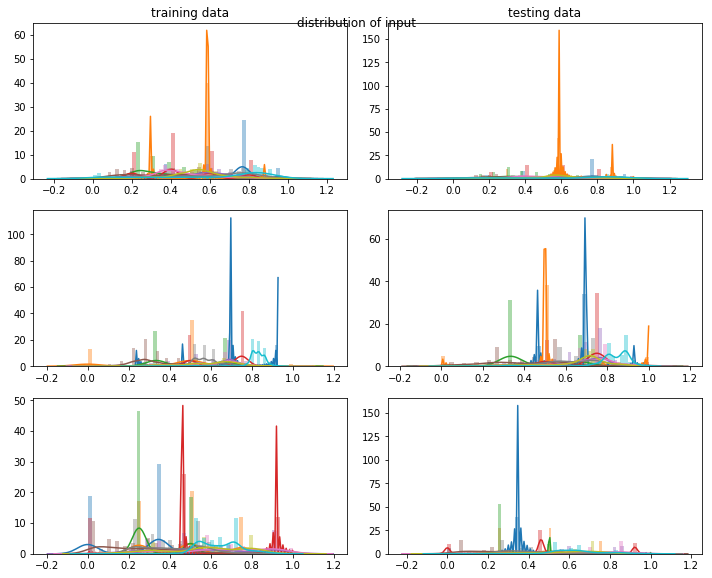

In [17]:
if run_config['use_time_series']:
    plots.plot_2d_distribution(data_train[:,-1,:], data_test[:, -1, :])
else:
    plots.plot_2d_distribution(data_train, data_test);

## Use *tf.data* to create batches and shuffle the dataset

In [18]:
def to_tf_data(X):
    return tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).batch(run_config['batch_size'])

train_dataset = to_tf_data(data_train)
test_dataset = to_tf_data(data_test) 

# model def

## doc

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)

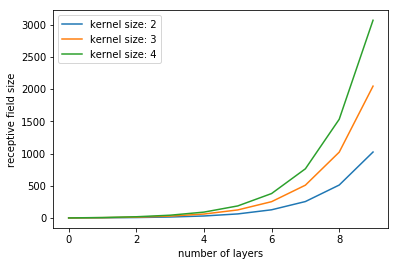

In [19]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return (1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1))

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## code

In [20]:
# Source: https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7

class TemporalBlock(tfkl.Layer):
    def __init__(self, n_outputs, kernel_size, dilation_rate, dropout=0.2, trainable=True, name=None, dtype=None, activity_regularizer=None, **kwargs):
        """
        In the dilated convolution, the kernel only touches the signal at every lth entry 
        See https://www.inference.vc/dilated-convolutions-and-kronecker-factorisation/
        """
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs)        
        self.dropout = dropout
        self.n_outputs = n_outputs
        causal_conv_args = {"padding": "causal",
                            "dilation_rate": dilation_rate, 
                            "activation": tf.nn.relu}
        self.conv1 = tfkl.Conv1D(n_outputs, kernel_size, **causal_conv_args, name="conv1")
        self.conv2 = tfkl.Conv1D(n_outputs, kernel_size, **causal_conv_args, name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = -1
        # SpatialDropout1D proved to be much better. Original paper: https://arxiv.org/abs/1411.4280
        self.dropout1 = tfkl.SpatialDropout1D(self.dropout)
        self.dropout2 = tfkl.SpatialDropout1D(self.dropout)
        if input_shape[channel_dim] != self.n_outputs:
            # TODO why not a conv1d layer?
            # self.down_sample = tf.layers.Conv1D(
            #     self.n_outputs, kernel_size=1, 
            #     activation=None, data_format="channels_last", padding="valid")
            self.down_sample = tf.layers.Dense(self.n_outputs, activation=None)
        self.built = True
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout2(x, training=training)
        if self.down_sample is not None:
            inputs = self.down_sample(inputs)
        return tf.nn.relu(x + inputs)

class TemporalConvNet(tf.layers.Layer):
    def __init__(self, num_channels, kernel_size=3, dropout=0.2,
                 trainable=True, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalConvNet, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )
        
        # TODO why not use a sequential layer here?
        self.layers = [TemporalBlock(n_out_channels, 
                                     kernel_size,
                                     dilation_rate=2 ** i,
                                     dropout=dropout,
                                     name=f"temporal_block_{i}") 
                       for i, n_out_channels in enumerate(num_channels)]
    
    def call(self, inputs, training=True):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs, training=training)
        return outputs

In [21]:
# build using:
#   - https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb 
#   - https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

def if_last(ls):
    for i, x in enumerate(ls):
        yield i + 1 == len(ls), x

def dense_layers(sizes, name, activation_fn=tf.nn.leaky_relu):
    # no activation in the last layer, because 
    return tfk.Sequential([tfkl.Dense(size, activation=None if is_last else activation_fn) for is_last, size in if_last(sizes)], 
                          name=name)


class R_VAE(tf.keras.Model):
    def __init__(self, latent_dim, input_shape, batch_size, n_layers=3, dropout_rate_temporal=0.2):
        """
        Args:
        -----
        
        latent_dim              int, dimension of latent space
        input_shape             tuple, total input shape is: [batch_size, *input_shape]
        batch_size              int
        n_layers                int, number of dense layers. 
                                output shape of the dense layers is linearly scaled.
        dropout_rate_temporal   float, in [0, 1). dropout rate for temporal blocks (conv layers).
        """
        super(R_VAE, self).__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self._batch_size = batch_size
        self._layer_sizes_inference  = np.linspace(input_shape[-1], 2 * latent_dim, n_layers).astype(np.int)
        # pseudo reverse as the inference network goes down to double the latent space, ask Semigh about this
        # the 2 * n_layers is to keep compression speed roughly the same
        self._layer_sizes_generative = np.linspace(latent_dim, input_shape[-1], 2 * n_layers).astype(np.int).tolist() + [input_shape[-1]]
        
        self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape[-1]),
                                                 dense_layers(self._layer_sizes_inference, name='inference_net_dense_layers')],
                                                 name='inference_net')

        self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                                  dense_layers(self._layer_sizes_generative, name='generative_net_dense_layers')],
                                                  name='generative_net')
        
        if len(input_shape) == 1:
            self.temporal_conv_net = None
        elif len(input_shape) == 2:
            self.temporal_conv_net = TemporalConvNet(num_channels=[input_shape[-1]] * 3,  
                                                     dropout=dropout_rate_temporal,
                                                     name='temporal_conv_net')
        else:
            raise ValueError(f"Input shape is not good, got: {input_shape}")
            
        print(self._config_())
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(self._batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
  
    def encode(self, x, training=False):
        if self.temporal_conv_net:
            # taking only the last entry
            x_tmp = tfkl.Lambda(lambda x: x[:, -1, :])(self.temporal_conv_net(x, training=training))
            mean, logvar = tf.split(self.inference_net(x_tmp), num_or_size_splits=2, axis=1)
        else:
            mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
  
    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
  
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
  
        return logits

    def predict(self, x):
        mean, logvar = self.encode(x)
        z = model.reparameterize(mean, logvar)
        return model.decode(z, apply_sigmoid=True)
    
    def _config_(self):
        return {
            "latent_dim": self.latent_dim,
            "input_shape": self._input_shape,
            "batch_size": self._batch_size,
            "layer_sizes_inference": self._layer_sizes_inference,
            "layer_sizes_generative": self._layer_sizes_generative,
        }

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [22]:
if run_config['use_time_series']:
    assert len(data_train.shape) == 3, 'run all the necessary code, shape does not align with config'
else:
    assert len(data_train.shape) == 2, 'run all the necessary code, shape does not align with config'

In [23]:
data_test.shape

(459, 10, 30)

In [24]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    if len(x.shape) == 2:
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    else:
        # Note, the model is trained to reconstruct only the last, most current time step (by taking the last entry in the timeseries)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:, -1, :])
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    
    # reconstruction loss
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1]) # down to [batch, loss]
    
    # KL loss
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x): 
    with tf.GradientTape() as tape: 
        loss = compute_loss(model, x) 
        return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

## training

In [25]:
epochs = 10

if run_config['debug'] and run_config['d_no_compression']:
    latent_dim=data_train.shape[-1]
else:
    latent_dim = 8

tf.reset_default_graph()
test_losses = []
train_losses = []

model = R_VAE(latent_dim, input_shape=data_train.shape[1:], batch_size=run_config['batch_size'], n_layers=4, dropout_rate_temporal=0.2)

model.inference_net.get_layer('inference_net_dense_layers').summary()
model.generative_net.get_layer('generative_net_dense_layers').summary()

{'latent_dim': 8, 'input_shape': (10, 30), 'batch_size': 100, 'layer_sizes_inference': array([30, 25, 20, 16]), 'layer_sizes_generative': ListWrapper([8, 11, 14, 17, 20, 23, 26, 30, 30])}
Model: "inference_net_dense_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                336       
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________
Model: "generative_net_dense_layers"
___________

In [26]:
print(f"will train model {model._config_()}, with global params: {run_config}")
# TODO add tensorboard stuff
def _compute_loss_for_data_(model, data):
    loss = tfe.metrics.Mean()
    for x in data:
        loss(compute_loss(model, x))
    elbo = -loss.result()
    
    return elbo

#print(f"will train for {epochs} epochs")
#for epoch in range(1, epochs + 1):
print(f"will train for ever...")
epoch = len(train_losses)
while True:
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    test_losses += [_compute_loss_for_data_(model, test_dataset)]
    train_losses += [_compute_loss_for_data_(model, train_dataset)]

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:0>3}, train test loss: {test_losses[-1]:0.3f}, took {end_time - start_time:0.3f} sec")
        
    epoch += 1

will train model {'latent_dim': 8, 'input_shape': (10, 30), 'batch_size': 100, 'layer_sizes_inference': array([30, 25, 20, 16]), 'layer_sizes_generative': ListWrapper([8, 11, 14, 17, 20, 23, 26, 30, 30])}, with global params: {'debug': False, 'd_zero_data': True, 'd_no_compression': True, 'use_all_experiments': False, 'use_time_series': True, 'use_2d_data': True, 'time_series_length': 10, 'batch_size': 100}
will train for ever...
Epoch: 000, train test loss: -25.975, took 1.789 sec
Epoch: 010, train test loss: -21.754, took 0.530 sec
Epoch: 020, train test loss: -20.798, took 0.555 sec
Epoch: 030, train test loss: -20.456, took 0.537 sec
Epoch: 040, train test loss: -20.302, took 0.534 sec
Epoch: 050, train test loss: -20.199, took 0.564 sec
Epoch: 060, train test loss: -20.145, took 0.576 sec
Epoch: 070, train test loss: -20.145, took 0.579 sec
Epoch: 080, train test loss: -20.039, took 0.566 sec
Epoch: 090, train test loss: -20.076, took 0.552 sec


KeyboardInterrupt: 

In [27]:
len(train_losses)

94

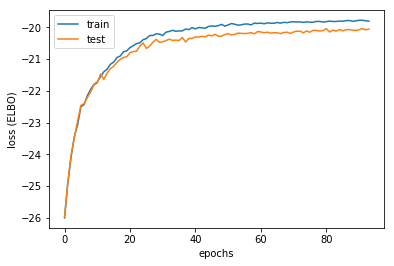

In [28]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epochs')
plt.ylabel('loss (ELBO)')
plt.legend()

In [29]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    input_shape = (15, -1)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

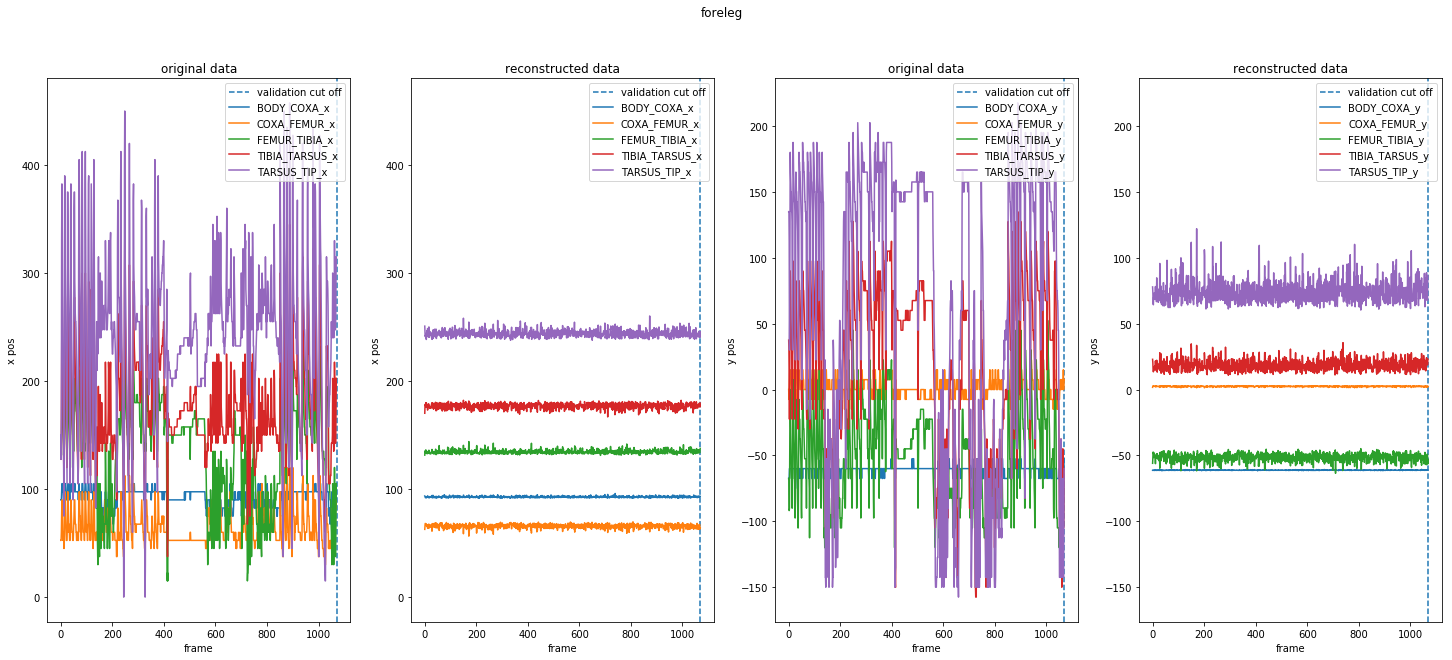

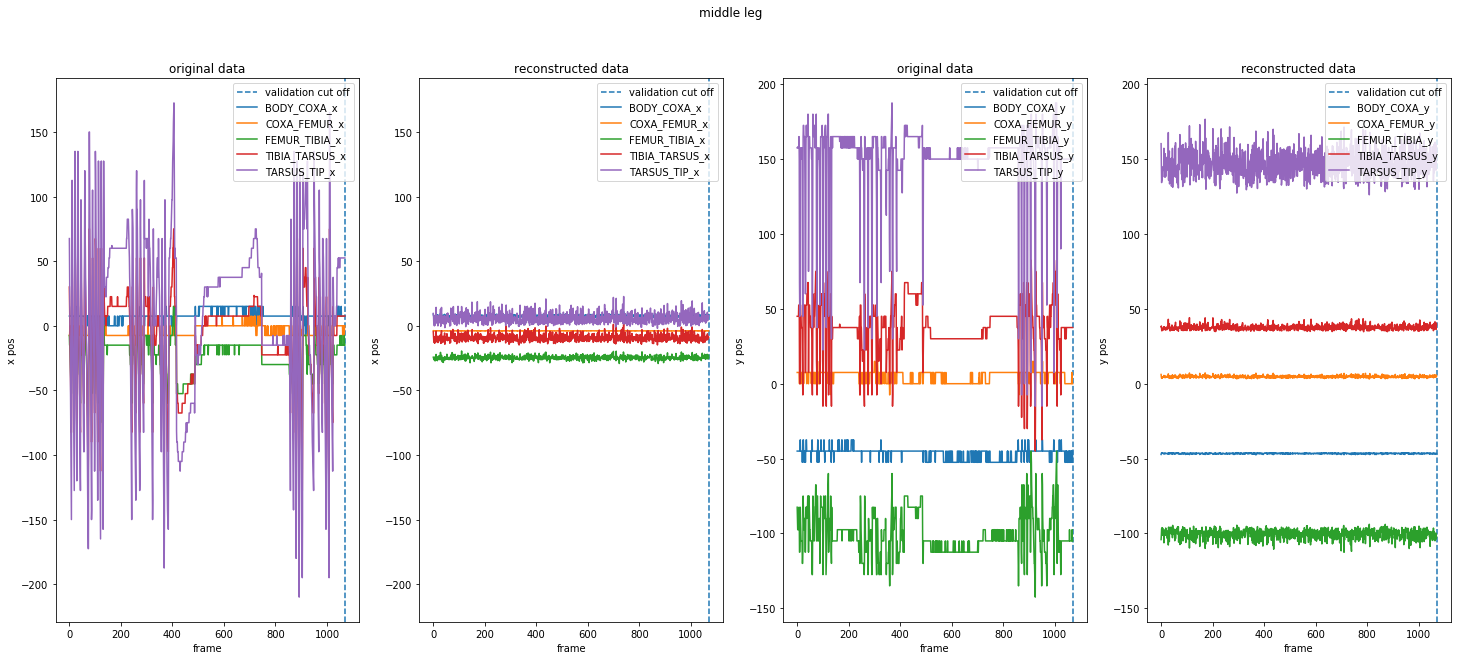

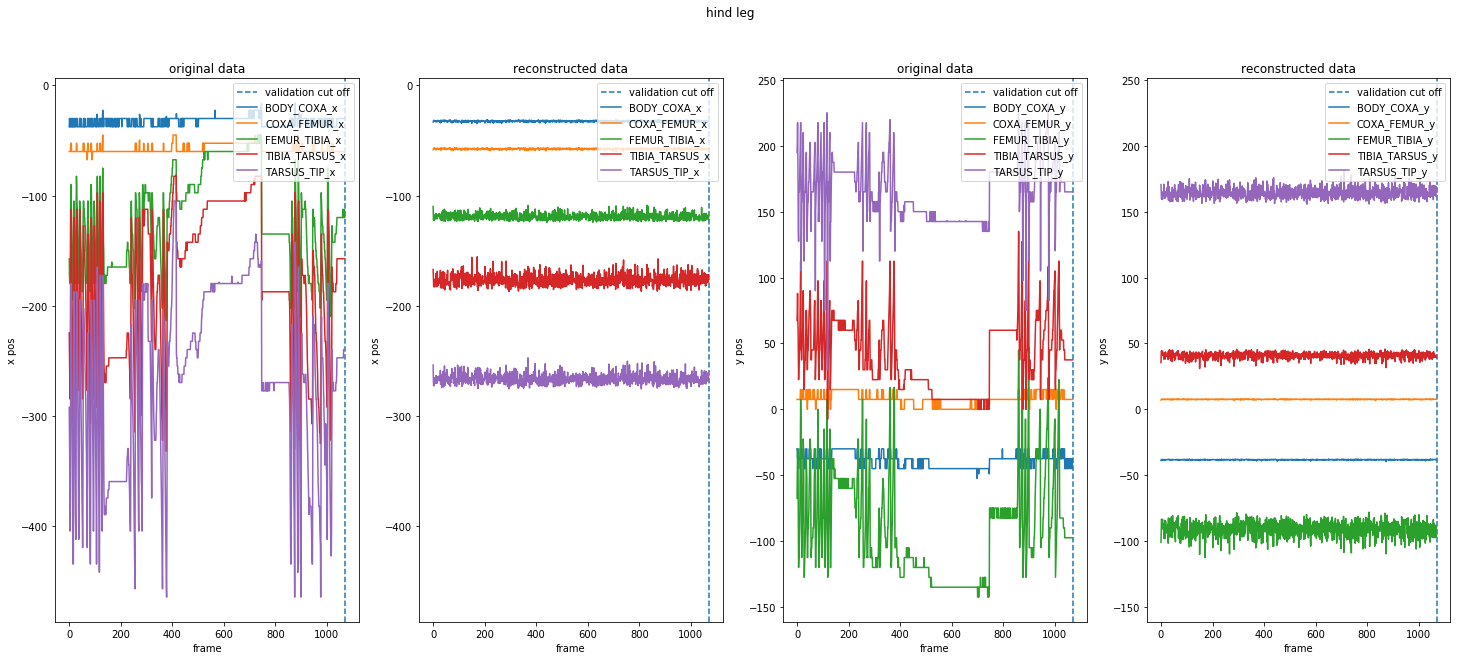

In [31]:
gen_pos_data = _reverse_to_original_shape_(np.vstack([model.sample().numpy() for _ in range(11)]))

if run_config['use_time_series']: 
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train[:, -1, :]), 
                                                           gen_pos_data[:data_train.shape[0]],
                                                           validation_cut_off=data_train.shape[0])
else:
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), 
                                                           gen_pos_data[:data_train.shape[0]],
                                                           validation_cut_off=data_train.shape[0])

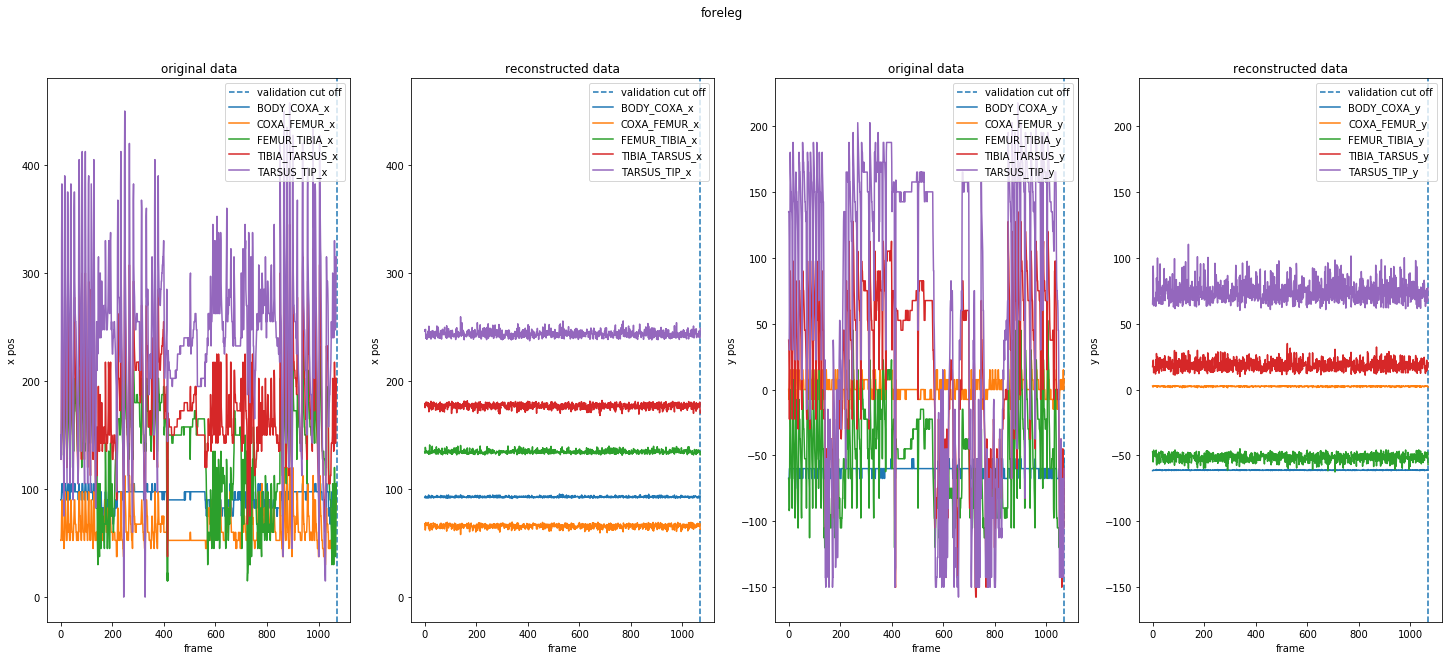

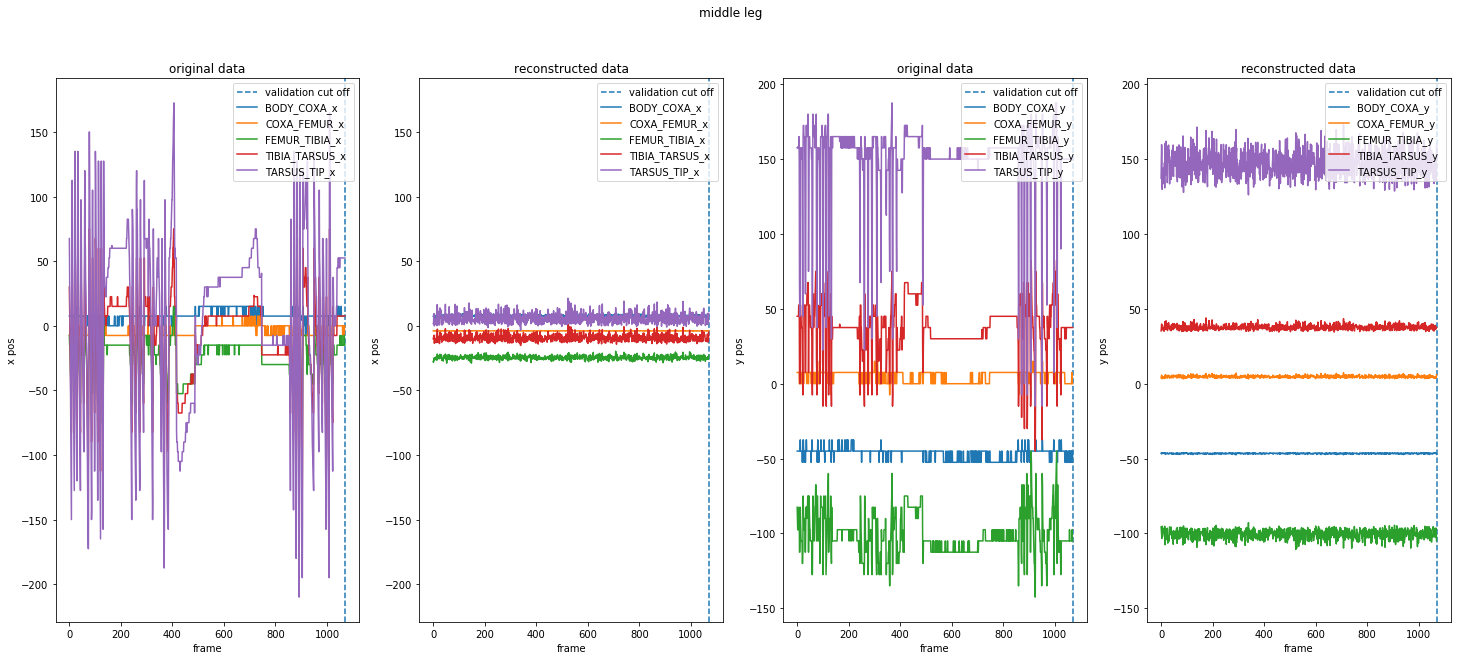

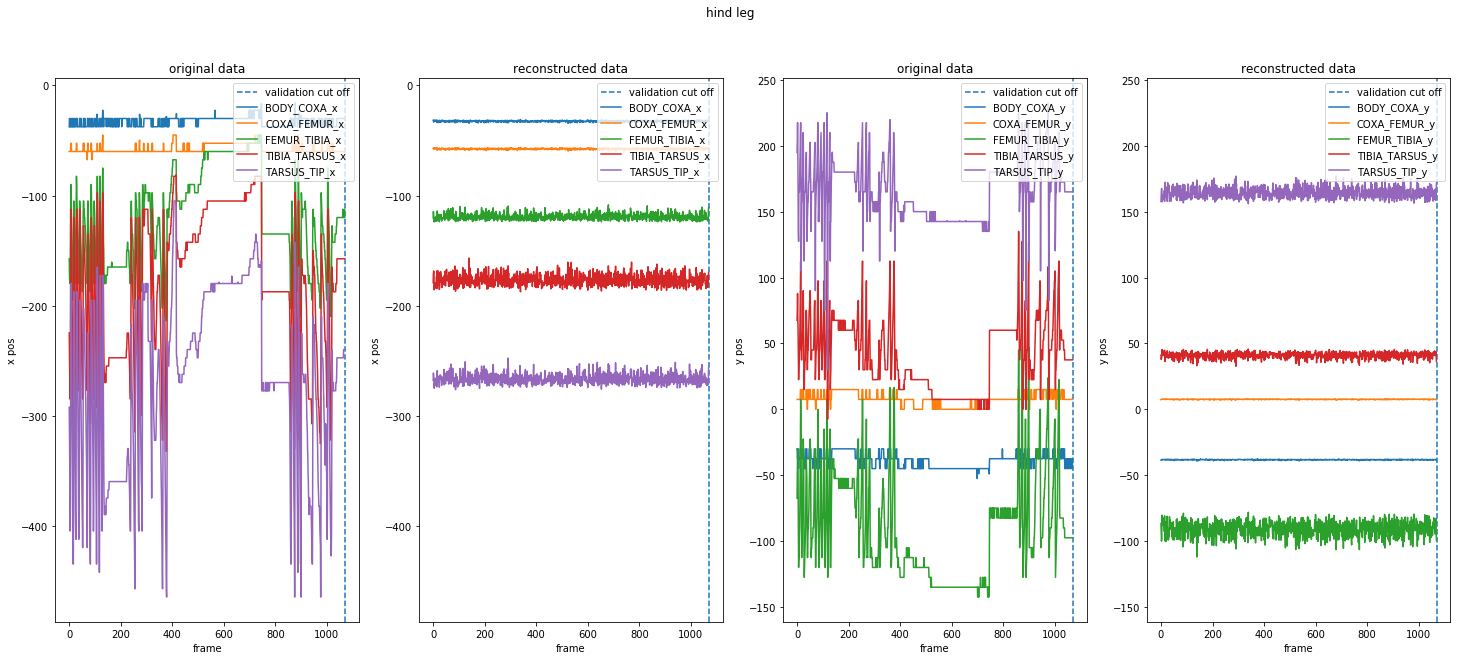

In [32]:
pred_train = model.predict(data_train).numpy()
pred_train_rev = _reverse_to_original_shape_(model.predict(data_train).numpy())

if run_config['use_time_series']: 
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train[:, -1, :]),
                                                           pred_train_rev,
                                                           validation_cut_off=data_train.shape[0])
else:
    plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), 
                                                           pred_train_rev,
                                                           validation_cut_off=data_train.shape[0])

In [577]:
stop
reload(plots)
if config.NB_DIMS == 3:
    if som_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]
    else:
        timed_jp = joint_positions
        
    f = plots.plot_reconstructed_angle_data(real_data=timed_jp,
                                            reconstructed_data=np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                            columns=angled_data_columns)
    p = f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_angled_plot_.png"
    pathlib.Path(p).parent.mkdir(exist_ok=True)
    f.savefig(p)
else:
    if som_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]

        plots.plot_comparing_joint_position_with_reconstructed(timed_jp, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)
    else:
        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)

        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val)), 
                                                               validation_cut_off=nb_of_data_points)

NameError: name 'stop' is not defined

# Graveyard

In [ ]:
#class TemporalBlock(tf.keras.Model):
#    def __init__(self, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0.0): 
#        super(TemporalBlock, self).__init__()
#        # TODO check if this is correct
#        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
#        assert padding in ['causal', 'same']
#
#        # block1
#        self.conv1  = tfkl.Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
#        self.batch1 = tfkl.BatchNormalization(axis=-1)
#        self.ac1    = tfkl.Activation('relu')
#        self.drop1  = tfkl.Dropout(rate=dropout_rate)
#        
#        # block2
#        self.conv2  = tfkl.Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
#        self.batch2 = tfkl.BatchNormalization(axis=-1)        
#        self.ac2    = tfkl.Activation('relu')
#        self.drop2  = tfkl.Dropout(rate=dropout_rate)
#
#        self.downsample = tfkl.Conv1D(filters=nb_filters, kernel_size=1, padding='same', kernel_initializer=init)
#        self.ac3    = tfkl.Activation('relu')
#
#
#    def call(self, x, training):
#        prev_x = x
#        x = self.conv1(x)
#        x = self.batch1(x)
#        x = self.ac1(x)
#        x = self.drop1(x) if training else x
#
#        x = self.conv2(x)
#        x = self.batch2(x)
#        x = self.ac2(x)
#        x = self.drop2(x) if training else x
#
#        if prev_x.shape[-1] != x.shape[-1]:    # match the dimention
#            prev_x = self.downsample(prev_x)
#        assert prev_x.shape == x.shape
#
#        return self.ac3(prev_x + x)            # skip connection
#
#
#
#class TemporalConvNet(tf.keras.Model):
#    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
#        # num_channels is a list contains hidden sizes of Conv1D
#        super(TemporalConvNet, self).__init__()
#        assert isinstance(num_channels, list)
#
#        model = tf.keras.Sequential()
#
#        # The model contains "num_levels" TemporalBlock
#        num_levels = len(num_channels)
#        for i in range(num_levels):
#            dilation_rate = 2 ** i                  # exponential growth
#            model.add(TemporalBlock(dilation_rate=dilation_rate, nb_filters=num_channels[i], kernel_size=kernel_size, padding='causal', dropout_rate=dropout))
#        self.network = model
#
#    def call(self, x, training):
#        return self.network(x, training=training)

# V3
from typing import List, Tuple

import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model


def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):
    # type: (Layer, int, int, int, str, float) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN

    Args:
        x: The previous layer in the model
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.

    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        # x = BatchNormalization()(x)  # TODO should be WeightNorm here.
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN(tf.layers.Layer):
    """Creates a TCN layer.

        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.

        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16, 32],
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")


    def __call__(self, inputs):
        x = inputs
        # 1D FCN.
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x,
                                             dilation_rate=d,
                                             nb_filters=self.nb_filters,
                                             kernel_size=self.kernel_size,
                                             padding=self.padding,
                                             dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        if not self.return_sequences:
            x = Lambda(lambda tt: tt[:, -1, :])(x)
        return x